In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# --- Configuration ---
# You can adjust these parameters to change the size and characteristics of the dataset
N_DEVICES = 50  # Total number of devices in the dataset
N_FAILING_DEVICES = 15  # Number of devices that will experience a failure
TIME_START = datetime(2023, 1, 1)  # Start date for the time-series data
TIME_END = datetime(2023, 12, 31)  # End date for the time-series data
SAMPLING_INTERVAL_HOURS = 6  # The interval in hours between data points

# --- Function to generate data for a single device ---
def generate_device_data(device_id, is_failing):
    """
    This function generates a time-series dataset for a single smartphone.
    It simulates various telemetry data like battery level, CPU usage, etc.
    If 'is_failing' is True, it introduces anomalies in the data to simulate a failing device.
    """
    # Create a range of timestamps for the device
    timestamps = pd.to_datetime(np.arange(TIME_START, TIME_END, timedelta(hours=SAMPLING_INTERVAL_HOURS)))
    n_samples = len(timestamps)
    df = pd.DataFrame({'timestamp': timestamps, 'device_id': device_id})

    # --- Generate features for a healthy device ---
    # These lines generate random data for each feature, with some patterns to make it more realistic
    df['battery_level'] = 100 - (np.sin(np.arange(n_samples) / (24 / SAMPLING_INTERVAL_HOURS) * np.pi) + 1) * 40 + np.random.normal(0, 2, n_samples)
    df['cpu_usage_percent'] = np.random.uniform(5, 30, n_samples) + np.sin(np.arange(n_samples) / 50) * 10
    df['memory_usage_percent'] = np.random.uniform(40, 60, n_samples) + np.random.normal(0, 5, n_samples)
    df['storage_usage_percent'] = np.linspace(20, 80, n_samples) + np.random.normal(0, 1, n_samples) # Storage fills up over time
    df['app_crashes'] = np.random.poisson(0.05, n_samples)
    df['network_signal_strength_dbm'] = np.random.uniform(-110, -80, n_samples)
    df['screen_on_time_minutes'] = np.random.exponential(30, n_samples)
    df['fast_charging_active'] = np.random.choice([0, 1], size=n_samples, p=[0.8, 0.2])
    df['speaker_volume_percent'] = np.random.uniform(0, 100, n_samples)
    df['ambient_temp_c'] = np.random.uniform(15, 35, n_samples) + np.sin(np.arange(n_samples) / (365 * 24 / SAMPLING_INTERVAL_HOURS) * 2 * np.pi) * 5 # Seasonal temp change

    # --- Introduce anomalies for failing devices ---
    if is_failing:
        # Determine the point of failure and the period of degradation
        failure_point = int(n_samples * np.random.uniform(0.8, 0.95)) # Fails in the last 5-20% of its life
        degradation_period = int(n_samples * 0.15) # Show signs of failure in the last 15% of life

        # Introduce anomalies in the data to simulate a failing device
        df.loc[failure_point - degradation_period:, 'battery_level'] *= np.linspace(1, 0.7, n_samples - (failure_point - degradation_period))
        df.loc[failure_point - degradation_period:, 'cpu_usage_percent'] += np.linspace(0, 30, n_samples - (failure_point - degradation_period))
        df.loc[failure_point - degradation_period:, 'memory_usage_percent'] += np.linspace(0, 25, n_samples - (failure_point - degradation_period))
        df.loc[failure_point - degradation_period:, 'app_crashes'] += np.random.poisson(0.5, n_samples - (failure_point - degradation_period))
        df.loc[failure_point - degradation_period:, 'ambient_temp_c'] += np.linspace(0, 15, n_samples - (failure_point - degradation_period))

        # --- Set target variable ---
        # The target variable 'failed_in_next_7d' is set to 1 for the 7 days leading up to the failure
        df['failed_in_next_7d'] = 0
        failure_window_start = failure_point - int(7 * 24 / SAMPLING_INTERVAL_HOURS)
        df.loc[failure_window_start:failure_point, 'failed_in_next_7d'] = 1
    else:
        # For healthy devices, the target variable is always 0
        df['failed_in_next_7d'] = 0

    # Clip values to be within realistic bounds (e.g., battery level cannot be > 100)
    df['battery_level'] = df['battery_level'].clip(0, 100)
    df['cpu_usage_percent'] = df['cpu_usage_percent'].clip(0, 100)
    df['memory_usage_percent'] = df['memory_usage_percent'].clip(0, 100)
    df['storage_usage_percent'] = df['storage_usage_percent'].clip(0, 100)

    return df

# --- Generate data for all devices and combine ---
all_devices_df = []
failing_device_ids = [f"device_{i:03d}" for i in range(N_FAILING_DEVICES)]

# Loop through each device and generate its data
for i in range(N_DEVICES):
    device_id = f"device_{i:03d}"
    is_failing = device_id in failing_device_ids
    device_df = generate_device_data(device_id, is_failing)
    all_devices_df.append(device_df)

# Concatenate the data from all devices into a single DataFrame
final_df = pd.concat(all_devices_df, ignore_index=True)

# --- Save to CSV ---
final_df.to_csv('smartphone_telemetry.csv', index=False)

print("Smartphone telemetry dataset generated and saved to 'smartphone_telemetry.csv'")

Smartphone telemetry dataset generated and saved to 'smartphone_telemetry.csv'


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
from tqdm import tqdm
import os

# --- Configuration ---
INPUT_CSV = "smartphone_telemetry.csv"
OUTPUT_PATH = "."

# Define the sequence length based on the data's 6-hour interval
SAMPLING_INTERVAL_HOURS = 6
TIMESTEPS_PER_DAY = 24 // SAMPLING_INTERVAL_HOURS
SEQUENCE_DAYS = 14  # We'll look at 14 days of history for each prediction
SEQUENCE_TIMESTEPS = SEQUENCE_DAYS * TIMESTEPS_PER_DAY

def prepare_smartphone_data():
    """
    Loads raw smartphone data, scales it, creates sequences, and saves the final arrays.
    """
    print("--- Step 1: Loading and Preprocessing Data ---")

    try:
        # Define efficient data types
        dtype_map = {
            'battery_level': 'float32', 'cpu_usage_percent': 'float32', 'memory_usage_percent': 'float32',
            'storage_usage_percent': 'float32', 'app_crashes': 'int8', 'network_signal_strength_dbm': 'float32',
            'screen_on_time_minutes': 'float32', 'fast_charging_active': 'int8', 'speaker_volume_percent': 'float32',
            'ambient_temp_c': 'float32', 'failed_in_next_7d': 'int8'
        }
        df = pd.read_csv(INPUT_CSV, dtype=dtype_map, parse_dates=['timestamp'])
    except FileNotFoundError:
        print(f"Error: The file '{INPUT_CSV}' was not found.")
        return

    df.sort_values(by=['device_id', 'timestamp'], inplace=True)
    print(f"Loaded {len(df)} data points from {df['device_id'].nunique()} devices.")

    # --- Step 2: Scaling Features ---

    # Define the features the LSTM will use
    feature_columns = [
        'battery_level', 'cpu_usage_percent', 'memory_usage_percent',
        'storage_usage_percent', 'app_crashes', 'network_signal_strength_dbm',
        'screen_on_time_minutes', 'fast_charging_active', 'speaker_volume_percent',
        'ambient_temp_c'
    ]

    print(f"\n--- Step 2: Scaling {len(feature_columns)} Features ---")

    scaler = MinMaxScaler()
    df[feature_columns] = scaler.fit_transform(df[feature_columns])

    scaler_filename = os.path.join(OUTPUT_PATH, "smartphone_scaler.joblib")
    joblib.dump(scaler, scaler_filename)
    print(f"Scaler saved to '{scaler_filename}'.")

    # --- Step 3: Creating Sequences ---

    print(f"\n--- Step 3: Creating Sequences with {SEQUENCE_TIMESTEPS} Timesteps ({SEQUENCE_DAYS} days) ---")

    sequences = []
    labels = []

    grouped_data = df.groupby('device_id')

    for device_id, device_data in tqdm(grouped_data, desc="Processing Devices"):
        feature_data = device_data[feature_columns].values
        label_data = device_data['failed_in_next_7d'].values

        for i in range(len(feature_data) - SEQUENCE_TIMESTEPS):
            seq = feature_data[i:i + SEQUENCE_TIMESTEPS]
            label = label_data[i + SEQUENCE_TIMESTEPS - 1]

            sequences.append(seq)
            labels.append(label)

    X = np.array(sequences)
    y = np.array(labels)

    print("\n--- Step 4: Finalizing and Saving Data ---")
    print(f"Final shape of sequences (X): {X.shape}")
    print(f"Final shape of labels (y): {y.shape}")

    np.save(os.path.join(OUTPUT_PATH, "smartphone_sequences.npy"), X)
    np.save(os.path.join(OUTPUT_PATH, "smartphone_labels.npy"), y)

    print(f"\nData preparation complete. Model-ready files saved.")
    print("You are now ready for the next step: training the LSTM model.")


if __name__ == "__main__":
    prepare_smartphone_data()

--- Step 1: Loading and Preprocessing Data ---
Loaded 72800 data points from 50 devices.

--- Step 2: Scaling 10 Features ---
Scaler saved to './smartphone_scaler.joblib'.

--- Step 3: Creating Sequences with 56 Timesteps (14 days) ---


Processing Devices: 100%|██████████| 50/50 [00:00<00:00, 168.13it/s]



--- Step 4: Finalizing and Saving Data ---
Final shape of sequences (X): (70000, 56, 10)
Final shape of labels (y): (70000,)

Data preparation complete. Model-ready files saved.
You are now ready for the next step: training the LSTM model.


--- Step 0: Setup and GPU Check ---
TensorFlow Version: 2.19.0


--- Step 1: Loading and Splitting Data ---
Loaded sequences with shape: (70000, 56, 10)
Loaded labels with shape: (70000,)

Training data shape: (56000, 56, 10)
Testing data shape: (14000, 56, 10)

--- Step 2: Calculating Class Weights ---
Calculated class weights: {0: np.float64(0.5031265722705384), 1: np.float64(80.45977011494253)}

--- Step 3: Building the LSTM Model ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 56, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 56, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,161 (125.63 KB)

 Trainable params: 32,161 (125.63 KB)

 Non-trainable params: 0 (0.00 B)


--- Step 4: Compiling and Training the Model ---
Epoch 1/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 63s 129ms/step - accuracy: 0.7681 - loss: 0.4491 - precision: 0.0277 - recall: 0.8515 - val_accuracy: 0.9509 - val_loss: 0.1544 - val_precision: 0.1123 - val_recall: 1.0000
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 59s 134ms/step - accuracy: 0.8522 - loss: 0.2259 - precision: 0.0470 - recall: 0.9873 - val_accuracy: 0.9436 - val_loss: 0.1774 - val_precision: 0.0992 - val_recall: 1.0000
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 55s 126ms/step - accuracy: 0.7094 - loss: 0.3629 - precision: 0.0332 - recall: 0.9321 - val_accuracy: 0.9338 - val_loss: 0.2970 - val_precision: 0.0858 - val_recall: 1.0000
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 55s 126ms/step - accuracy: 0.9386 - loss: 0.1487 - precision: 0.0918 - recall: 0.9884 - val_accuracy: 0.9516 - val_loss: 0.1439 - val_precision: 0.1137 - val_recall: 1.0000
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 61s 140ms/step - accuracy: 0.9449 - loss: 0.1294 - precisi

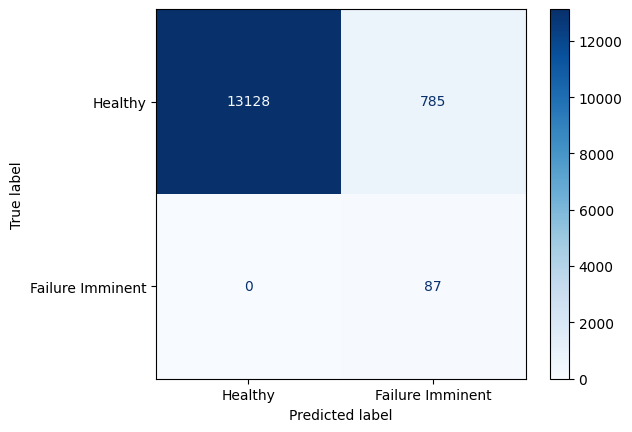


Model training and evaluation complete. Model saved to 'smartphone_model.h5'.


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import os

# --- Step 0: Setup and GPU Check ---
print("--- Step 0: Setup and GPU Check ---")
print(f"TensorFlow Version: {tf.__version__}")

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('\nWARNING: GPU device not found. Training will be much slower.')
else:
  print('\nSUCCESS: Found GPU at: {}'.format(device_name))


# --- Step 1: Load and Split Data ---
print("\n--- Step 1: Loading and Splitting Data ---")
X_FILE = 'smartphone_sequences.npy'
Y_FILE = 'smartphone_labels.npy'

if not os.path.exists(X_FILE) or not os.path.exists(Y_FILE):
    print(f"Error: Make sure '{X_FILE}' and '{Y_FILE}' are uploaded to your Colab session.")
else:
    X = np.load(X_FILE)
    y = np.load(Y_FILE)

    print(f"Loaded sequences with shape: {X.shape}")
    print(f"Loaded labels with shape: {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nTraining data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")


# --- Step 2: Handle Class Imbalance ---
print("\n--- Step 2: Calculating Class Weights ---")

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Calculated class weights: {class_weight_dict}")


# --- Step 3: Build the LSTM Model Architecture ---
print("\n--- Step 3: Building the LSTM Model ---")

input_shape = (X_train.shape[1], X_train.shape[2]) # (timesteps, features)

model = Sequential([
    LSTM(64, input_shape=input_shape, return_sequences=True), # Return sequences for stacking
    Dropout(0.2),
    LSTM(32, return_sequences=False), # Last LSTM layer
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()


# --- Step 4: Compile and Train the Model ---
print("\n--- Step 4: Compiling and Training the Model ---")

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

history = model.fit(
    X_train,
    y_train,
    epochs=15, # Increased epochs slightly for potentially more complex patterns
    batch_size=128,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict
)





--- Step 5: Evaluating Model Performance ---
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step

Classification Report:
                  precision    recall  f1-score   support

         Healthy       1.00      0.96      0.98     13913
Failure Imminent       0.14      0.95      0.25        87

        accuracy                           0.96     14000
       macro avg       0.57      0.96      0.62     14000
    weighted avg       0.99      0.96      0.98     14000


Confusion Matrix:


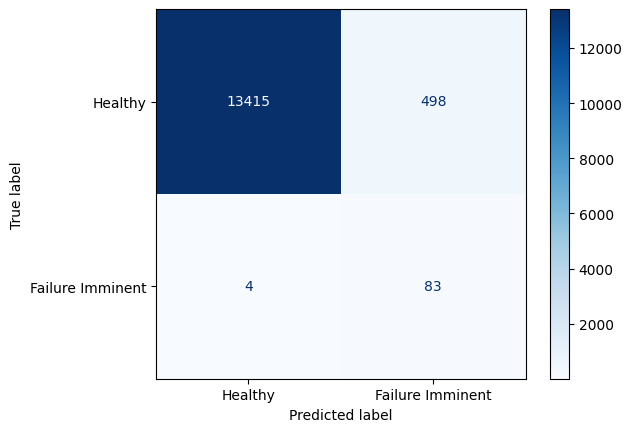


Model training and evaluation complete. Model saved to 'smartphone_model.h5'.


In [29]:
# --- Step 5: Evaluate the Model ---
print("\n--- Step 5: Evaluating Model Performance ---")

y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.9438999).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Failure Imminent']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Failure Imminent'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# --- Step 6: Save the Trained Model ---
MODEL_FILENAME = 'smartphone_model.h5'
model.save(MODEL_FILENAME)
print(f"\nModel training and evaluation complete. Model saved to '{MODEL_FILENAME}'.")